In [1]:
%matplotlib notebook
%config InlineBackend.figure_format = 'retina'

The following code was to simulate the experiment in the Berg and Marshall paper specifically (more or less)

In [34]:
# -*- coding: utf-8 -*-
"""
Created on Thu Apr 23 00:00:08 2020

@author: Rokka
"""

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython import display

class Wilberforce:
    #omega_z = omega_theta = omega
    def __init__(self,z0,theta0,v0,rv0): #z0,theta0 = initial conditions, spring constants,omega = oscillation freq.
        self.z = z0                      #initial z
        self.theta = theta0              #initial theta
        self.v = v0                      #initial longitudinal velocity
        self.rv = rv0                    #initial rotational velocity
        self.k = 2.8                     #longitudinal spring constant
        self.delta = 7.86e-4             #torsional spring constant
        self.m = 0.5164                  #mass (kg)
        self.I = 1.45e-4                 #moment of Inertia
        self.epsilon = 9.27e-3           #coupling constant  (Berg & Marshall)
        
        self.omega2 = self.k/self.m      #k/m = I/delta
        self.alpha = self.epsilon/(2*self.delta)
        self.beta = self.epsilon/(2*self.k)
        
        self.z_array = []
        self.theta_array = []
        self.v_array = []
        self.rv_array = []
        self.time = []
    
    def F(self,z,theta,v,rv,t):              #returns zdot, zdouble-dot, theta-dot, theta-double-dot (dimensionless)
        return np.array([v/self.omega2, -z - (self.beta*theta), rv/self.omega2, -theta - (self.alpha*z)])       

    def rk4_step(self,F,z,theta,v,rv,t):     #rk4 copied from Lab 8 (modified for Wilberforce pend.)
        k1 = dt*F(z,theta,v,rv,t)         
        k2 = dt*F(z + 0.5*k1[0], theta + 0.5*k1[2],v + 0.5*k1[1],rv + 0.5*k1[3],t+dt/2)
        k3 = dt*F(z + 0.5*k2[0], theta + 0.5*k2[2],v + 0.5*k2[1],rv + 0.5*k2[3],t+dt/2)
        k4 = dt*F(z + k3[0], theta + k3[2],v + k3[1],rv + k3[3],t+dt)
        z = z + (k1[0] + 2*k2[0] + 2*k3[0] + k4[0])/6.
        v = v + (k1[1] + 2*k2[1] + 2*k3[1] + k4[1])/6.
        theta = theta + (k1[2] + 2*k2[2] + 2*k3[2] + k4[2])/6.
        rv = rv + (k1[3] + 2*k2[3] + 2*k3[3] + k4[3])/6.
        return np.array(z),np.array(v),np.array(theta),np.array(rv)
    
    def pendulum(self,tfinal,dt):           #like rk4_chain function in lab 8
        t = 0.0
        while t < tfinal+dt:
            zn = self.z
            thetan = self.theta
            vn = self.v
            rvn = self.rv
            self.time.append(t/self.omega2)
            self.z_array.append(self.z)
            self.v_array.append(self.v)
            self.theta_array.append(self.theta)
            self.rv_array.append(self.rv)
            self.z,self.v,self.theta,self.rv = self.rk4_step(self.F,zn,thetan,vn,rvn,t)           
            t = t + dt    
            
    def energy(self,):                 #E = kinetic + potential    
        ve = np.array(self.v_array)    
        rve = np.array(self.rv_array)  
        ze = np.array(self.z_array)
        thee = np.array(self.theta_array)
        self.El = (0.5)*self.m*(ve**2) + (0.5)*self.k*(ze**2)            #(1/2)mv^2 + (1/2)kz^2
        self.Er = (0.5)*self.I*(rve**2) + (0.5)*self.delta*(thee**2)     #(1/2)I(vr)^2 + (1/2)(delta)(theta)^2
        self.Etot = self.El + self.Er                                    #Combined Energy
        return np.array(self.El), np.array(self.Er), np.array(self.Etot)
    
    def plot_motion(self):
        #plots the z & theta vs. time graph (w/ shared time axis)
        #Not my code; from Wilberforce pend. on "scipython.com" blog
        fig, ax_z = plt.subplots(1,1,figsize=(12,3))
        l_z, = ax_z.plot(self.time,self.z_array,'g', label=r'$z$')
        ax_z.set_xlabel('time (sec)')
        ax_z.set_ylabel(r'$z$ (m)')
        ax_theta = ax_z.twinx()
        l_theta, = ax_theta.plot(self.time, self.theta_array,'orange',label=r'$\theta$')
        ax_theta.set_ylabel(r'$\theta$ (radians)')
        lines = (l_z, l_theta)
        labels = [line.get_label() for line in lines]
        plt.legend(lines, labels,loc ='upper left',bbox_to_anchor=(0,1.0))
        plt.title("Motion")
        #-----------------------------------------------------------
        #plots z vs. theta
        plt.figure()
        plt.plot(self.theta_array,self.z_array)
        plt.xlabel("$\\theta$ (radians)")
        plt.ylabel("z (m)")
        plt.title("z vs. $\\theta$")
    
    def plot_energy(self,):     
        [El,Er,Etot] = self.energy()
        plt.figure()
        plt.plot(self.time,Etot)
        plt.ylim(0,np.max(Etot)*2.5)
        plt.title("Combined Total Energy (Longitudinal + Torsional)")
        plt.xlabel("time (sec)")
        plt.ylabel("Energy (J)")
        plt.figure()
        plt.plot(self.time,El,label= "Longitudinal ($z$)")
        plt.plot(self.time,Er,label= "Tortional ($\\theta$)")
        plt.legend(loc ='upper left',bbox_to_anchor=(1.0,1.0))
        plt.title("Separate Energies")
        plt.xlabel("time (sec)")
        plt.ylabel("Energy (J)")
        
    def normal_modes(self):
        self.omega = np.sqrt(self.omega2)
        denom = 4*self.omega*np.sqrt(self.m*self.I)
        self.nm1 = self.omega + self.epsilon/denom
        self.nm2 = self.omega - self.epsilon/denom
        nmb = np.max(self.theta_array)
        plt.text(nmb+(nmb/2), 0.01,"Normal Modes: \nmode 1 = "+str(self.nm1)+" rad/s \nmode 2 ="+str(self.nm2)+" rad/s")

    def animate(self,nstep):
        theta = np.array(self.theta_array)
        lines1=[]
        lines2=[]
        fig1, ax = plt.subplots()
        fig2, ax2 = plt.subplots(subplot_kw={'projection': 'polar'})
        for a in range(0,int(len(self.time)),nstep):
            p1 = ax.plot(0.,self.z_array[a],'ro', markersize=25)
            p2 = ax2.plot(theta[a], np.ones(len(self.time))[a], 'bo',
                          theta[a] + np.pi, np.ones(len(self.time))[a], 'go',     # it helps to comment out these 
                          theta[a] + np.pi/2, np.ones(len(self.time))[a], 'co',   # three lines (points in the animation)
                          theta[a] - np.pi/2, np.ones(len(self.time))[a], 'yo',   # when playing with extreme initial conditions
                          markersize =10)                                              # just so it's easier to see the rotational motion
            lines1.append(p1)
            lines2.append(p2)
        ax.set_title("Longitudinal Motion")
        ax2.set_title("Rotational Motion")
        fig1.suptitle("$z_0$ = "+str(self.z_array[0])+"; $\\theta_0$ = "+str(self.theta_array[0]), fontweight='bold')
        ani = animation.ArtistAnimation(fig1, lines1, interval=5)
        anim = animation.ArtistAnimation(fig2, lines2, interval=5)
        return ani, anim
        
#===============================================================================================================

<IPython.core.display.Javascript object>


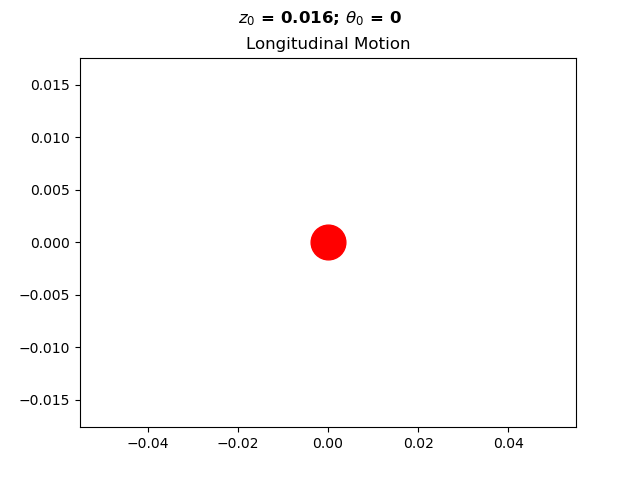

<IPython.core.display.Javascript object>


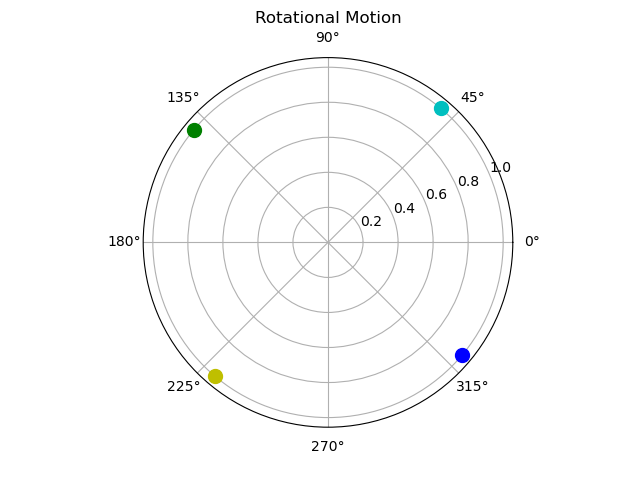

In [35]:
#Initial conditions 1 (Duplicate Berg and Marshall(more or less))
z0 = 0.016              #m
theta0 = 0          #radians  
v0 = 0
rv0 = 0
T = 150        
tfinal = T*2
dt = 0.1
WF1 = Wilberforce(z0,theta0,v0,rv0)
WF1.pendulum(tfinal,dt)
#WF1.plot_motion()
#plt.suptitle("Simulate Berg & Marshall",fontweight='bold')
anim,anim2 = WF1.animate(5)
#===========================================================================

# video = anim.to_html5_video()
# html = display.HTML(video)
# display.display(html)
# plt.close()     

In [9]:
with open("longit-vid.html","w") as f:
    print(anim.to_html5_video(),file=f)

In [10]:
with open("rotat-vid.html","w") as f:
    print(anim2.to_html5_video(),file=f)

In [25]:
vid = anim.to_html5_video()
vid2 = anim2.to_html5_video()

In [29]:
html = display.HTML(vid)
html2 = display.HTML(vid2)
display.display(html)
display.display(html2)

In [14]:
# -*- coding: utf-8 -*-
"""
Created on Thu Apr 23 00:00:08 2020

@author: Rokka
"""

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython import display

class Wilberforce:
    #omega_z = omega_theta = omega
    def __init__(self,z0,theta0,v0,rv0): #z0,theta0 = initial conditions, spring constants,omega = oscillation freq.
        self.z = z0                      #initial z
        self.theta = theta0              #initial theta
        self.v = v0                      #initial longitudinal velocity
        self.rv = rv0                    #initial rotational velocity
        self.k = 2.8                     #longitudinal spring constant
        self.delta = 7.86e-4             #torsional spring constant
        self.m = 0.5164                  #mass (kg)
        self.I = 1.45e-4                 #moment of Inertia
        self.epsilon = 9.27e-3           #coupling constant  (Berg & Marshall)
        
        self.omega2 = self.k/self.m      #k/m = I/delta
        self.alpha = self.epsilon/(2*self.delta)
        self.beta = self.epsilon/(2*self.k)
        
        self.z_array = []
        self.theta_array = []
        self.v_array = []
        self.rv_array = []
        self.time = []
    
    def F(self,z,theta,v,rv,t):              #returns zdot, zdouble-dot, theta-dot, theta-double-dot (dimensionless)
        return np.array([v/self.omega2, -z - (self.beta*theta), rv/self.omega2, -theta - (self.alpha*z)])       

    def rk4_step(self,F,z,theta,v,rv,t):     #rk4 copied from Lab 8 (modified for Wilberforce pend.)
        k1 = dt*F(z,theta,v,rv,t)         
        k2 = dt*F(z + 0.5*k1[0], theta + 0.5*k1[2],v + 0.5*k1[1],rv + 0.5*k1[3],t+dt/2)
        k3 = dt*F(z + 0.5*k2[0], theta + 0.5*k2[2],v + 0.5*k2[1],rv + 0.5*k2[3],t+dt/2)
        k4 = dt*F(z + k3[0], theta + k3[2],v + k3[1],rv + k3[3],t+dt)
        z = z + (k1[0] + 2*k2[0] + 2*k3[0] + k4[0])/6.
        v = v + (k1[1] + 2*k2[1] + 2*k3[1] + k4[1])/6.
        theta = theta + (k1[2] + 2*k2[2] + 2*k3[2] + k4[2])/6.
        rv = rv + (k1[3] + 2*k2[3] + 2*k3[3] + k4[3])/6.
        return np.array(z),np.array(v),np.array(theta),np.array(rv)
    
    def pendulum(self,tfinal,dt):           #like rk4_chain function in lab 8
        t = 0.0
        while t < tfinal+dt:
            zn = self.z
            thetan = self.theta
            vn = self.v
            rvn = self.rv
            self.time.append(t/self.omega2)
            self.z_array.append(self.z)
            self.v_array.append(self.v)
            self.theta_array.append(self.theta)
            self.rv_array.append(self.rv)
            self.z,self.v,self.theta,self.rv = self.rk4_step(self.F,zn,thetan,vn,rvn,t)           
            t = t + dt    
            
    def energy(self,):                 #E = kinetic + potential    
        ve = np.array(self.v_array)    
        rve = np.array(self.rv_array)  
        ze = np.array(self.z_array)
        thee = np.array(self.theta_array)
        self.El = (0.5)*self.m*(ve**2) + (0.5)*self.k*(ze**2)            #(1/2)mv^2 + (1/2)kz^2
        self.Er = (0.5)*self.I*(rve**2) + (0.5)*self.delta*(thee**2)     #(1/2)I(vr)^2 + (1/2)(delta)(theta)^2
        self.Etot = self.El + self.Er                                    #Combined Energy
        return np.array(self.El), np.array(self.Er), np.array(self.Etot)
    
    def plot_motion(self):
        #plots the z & theta vs. time graph (w/ shared time axis)
        #Not my code; from Wilberforce pend. on "scipython.com" blog
        fig, ax_z = plt.subplots(1,1,figsize=(12,3))
        l_z, = ax_z.plot(self.time,self.z_array,'g', label=r'$z$')
        ax_z.set_xlabel('time (sec)')
        ax_z.set_ylabel(r'$z$ (m)')
        ax_theta = ax_z.twinx()
        l_theta, = ax_theta.plot(self.time, self.theta_array,'orange',label=r'$\theta$')
        ax_theta.set_ylabel(r'$\theta$ (radians)')
        lines = (l_z, l_theta)
        labels = [line.get_label() for line in lines]
        plt.legend(lines, labels,loc ='upper left',bbox_to_anchor=(0,1.0))
        plt.title("Motion")
        #-----------------------------------------------------------
        #plots z vs. theta
        plt.figure()
        plt.plot(self.theta_array,self.z_array)
        plt.xlabel("$\\theta$ (radians)")
        plt.ylabel("z (m)")
        plt.title("z vs. $\\theta$")
    
    def plot_energy(self,):     
        [El,Er,Etot] = self.energy()
        plt.figure()
        plt.plot(self.time,Etot)
        plt.ylim(0,np.max(Etot)*2.5)
        plt.title("Combined Total Energy (Longitudinal + Torsional)")
        plt.xlabel("time (sec)")
        plt.ylabel("Energy (J)")
        plt.figure()
        plt.plot(self.time,El,label= "Longitudinal ($z$)")
        plt.plot(self.time,Er,label= "Tortional ($\\theta$)")
        plt.legend(loc ='upper left',bbox_to_anchor=(1.0,1.0))
        plt.title("Separate Energies")
        plt.xlabel("time (sec)")
        plt.ylabel("Energy (J)")
        
    def normal_modes(self):
        self.omega = np.sqrt(self.omega2)
        denom = 4*self.omega*np.sqrt(self.m*self.I)
        self.nm1 = self.omega + self.epsilon/denom
        self.nm2 = self.omega - self.epsilon/denom
        nmb = np.max(self.theta_array)
        plt.text(nmb+(nmb/2), 0.01,"Normal Modes: \nmode 1 = "+str(self.nm1)+" rad/s \nmode 2 ="+str(self.nm2)+" rad/s")

    def animate(self,nstep):
        theta = np.array(self.theta_array)
        lines1=[]
        lines2=[]
        fig = plt.figure()
        ax1 = plt.subplot(121)
        ax2 = plt.subplot(122,projection = 'polar')
        for a in range(0,int(len(self.time)),nstep):
            p1 = ax1.plot(0.,self.z_array[a],'ro', markersize=25)
            p2 = ax2.plot(theta[a], np.ones(len(self.time))[a], 'bo',
                          theta[a] + np.pi, np.ones(len(self.time))[a], 'go',     # it helps to comment out these 
                          theta[a] + np.pi/2, np.ones(len(self.time))[a], 'co',   # three lines (points in the animation)
                          theta[a] - np.pi/2, np.ones(len(self.time))[a], 'yo',   # when playing with extreme initial conditions
                          markersize =10)                                              # just so it's easier to see the rotational motion
            lines1.append(p1)
            lines2.append(p2)
        ax1.set_title("Longitudinal Motion")
        ax2.set_title("Rotational Motion")
#         ax1.title("$z_0$ = "+str(self.z_array[0])+"; $\\theta_0$ = "+str(self.theta_array[0]), fontweight='bold')
        anim1 = animation.ArtistAnimation(ax1, lines1, interval=5)
        anim2 = animation.ArtistAnimation(ax2, lines2, interval=5)
        return fig
#         return ani
#===============================================================================================================

<IPython.core.display.Javascript object>


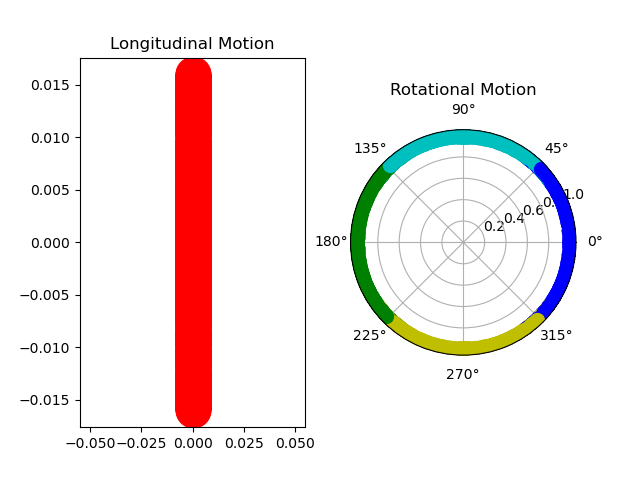

AttributeError: 'Axes' object has no attribute 'canvas'

In [15]:
#Initial conditions 1 (Duplicate Berg and Marshall(more or less))
z0 = 0.016              #m
theta0 = 0          #radians  
v0 = 0
rv0 = 0
T = 150        
tfinal = T*2
dt = 0.1
WF1 = Wilberforce(z0,theta0,v0,rv0)
WF1.pendulum(tfinal,dt)
#WF1.plot_motion()
#plt.suptitle("Simulate Berg & Marshall",fontweight='bold')
fig = WF1.animate(5)
# plt.show
#===========================================================================

In [11]:
vid = anim.to_html5_video()
html = display.HTML(vid)
display.display(html)
plt.close()

KeyboardInterrupt: 

In [19]:
# -*- coding: utf-8 -*-
"""
Created on Thu Apr 23 00:00:08 2020

@author: Rokka
"""

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython import display

class Wilberforce:
    #omega_z = omega_theta = omega
    def __init__(self,z0,theta0,v0,rv0): #z0,theta0 = initial conditions, spring constants,omega = oscillation freq.
        self.z = z0                      #initial z
        self.theta = theta0              #initial theta
        self.v = v0                      #initial longitudinal velocity
        self.rv = rv0                    #initial rotational velocity
        self.k = 2.8                     #longitudinal spring constant
        self.delta = 7.86e-4             #torsional spring constant
        self.m = 0.5164                  #mass (kg)
        self.I = 1.45e-4                 #moment of Inertia
        self.epsilon = 9.27e-3           #coupling constant  (Berg & Marshall)
        
        self.omega2 = self.k/self.m      #k/m = I/delta
        self.alpha = self.epsilon/(2*self.delta)
        self.beta = self.epsilon/(2*self.k)
        
        self.z_array = []
        self.theta_array = []
        self.v_array = []
        self.rv_array = []
        self.time = []
    
    def F(self,z,theta,v,rv,t):              #returns zdot, zdouble-dot, theta-dot, theta-double-dot (dimensionless)
        return np.array([v/self.omega2, -z - (self.beta*theta), rv/self.omega2, -theta - (self.alpha*z)])       

    def rk4_step(self,F,z,theta,v,rv,t):     #rk4 copied from Lab 8 (modified for Wilberforce pend.)
        k1 = dt*F(z,theta,v,rv,t)         
        k2 = dt*F(z + 0.5*k1[0], theta + 0.5*k1[2],v + 0.5*k1[1],rv + 0.5*k1[3],t+dt/2)
        k3 = dt*F(z + 0.5*k2[0], theta + 0.5*k2[2],v + 0.5*k2[1],rv + 0.5*k2[3],t+dt/2)
        k4 = dt*F(z + k3[0], theta + k3[2],v + k3[1],rv + k3[3],t+dt)
        z = z + (k1[0] + 2*k2[0] + 2*k3[0] + k4[0])/6.
        v = v + (k1[1] + 2*k2[1] + 2*k3[1] + k4[1])/6.
        theta = theta + (k1[2] + 2*k2[2] + 2*k3[2] + k4[2])/6.
        rv = rv + (k1[3] + 2*k2[3] + 2*k3[3] + k4[3])/6.
        return np.array(z),np.array(v),np.array(theta),np.array(rv)
    
    def pendulum(self,tfinal,dt):           #like rk4_chain function in lab 8
        t = 0.0
        while t < tfinal+dt:
            zn = self.z
            thetan = self.theta
            vn = self.v
            rvn = self.rv
            self.time.append(t/self.omega2)
            self.z_array.append(self.z)
            self.v_array.append(self.v)
            self.theta_array.append(self.theta)
            self.rv_array.append(self.rv)
            self.z,self.v,self.theta,self.rv = self.rk4_step(self.F,zn,thetan,vn,rvn,t)           
            t = t + dt    
            
    def energy(self,):                 #E = kinetic + potential    
        ve = np.array(self.v_array)    
        rve = np.array(self.rv_array)  
        ze = np.array(self.z_array)
        thee = np.array(self.theta_array)
        self.El = (0.5)*self.m*(ve**2) + (0.5)*self.k*(ze**2)            #(1/2)mv^2 + (1/2)kz^2
        self.Er = (0.5)*self.I*(rve**2) + (0.5)*self.delta*(thee**2)     #(1/2)I(vr)^2 + (1/2)(delta)(theta)^2
        self.Etot = self.El + self.Er                                    #Combined Energy
        return np.array(self.El), np.array(self.Er), np.array(self.Etot)
    
    def plot_motion(self):
        #plots the z & theta vs. time graph (w/ shared time axis)
        #Not my code; from Wilberforce pend. on "scipython.com" blog
        fig, ax_z = plt.subplots(1,1,figsize=(12,3))
        l_z, = ax_z.plot(self.time,self.z_array,'g', label=r'$z$')
        ax_z.set_xlabel('time (sec)')
        ax_z.set_ylabel(r'$z$ (m)')
        ax_theta = ax_z.twinx()
        l_theta, = ax_theta.plot(self.time, self.theta_array,'orange',label=r'$\theta$')
        ax_theta.set_ylabel(r'$\theta$ (radians)')
        lines = (l_z, l_theta)
        labels = [line.get_label() for line in lines]
        plt.legend(lines, labels,loc ='upper left',bbox_to_anchor=(0,1.0))
        plt.title("Motion")
        #-----------------------------------------------------------
        #plots z vs. theta
        plt.figure()
        plt.plot(self.theta_array,self.z_array)
        plt.xlabel("$\\theta$ (radians)")
        plt.ylabel("z (m)")
        plt.title("z vs. $\\theta$")
    
    def plot_energy(self,):     
        [El,Er,Etot] = self.energy()
        plt.figure()
        plt.plot(self.time,Etot)
        plt.ylim(0,np.max(Etot)*2.5)
        plt.title("Combined Total Energy (Longitudinal + Torsional)")
        plt.xlabel("time (sec)")
        plt.ylabel("Energy (J)")
        plt.figure()
        plt.plot(self.time,El,label= "Longitudinal ($z$)")
        plt.plot(self.time,Er,label= "Tortional ($\\theta$)")
        plt.legend(loc ='upper left',bbox_to_anchor=(1.0,1.0))
        plt.title("Separate Energies")
        plt.xlabel("time (sec)")
        plt.ylabel("Energy (J)")
        
    def normal_modes(self):
        self.omega = np.sqrt(self.omega2)
        denom = 4*self.omega*np.sqrt(self.m*self.I)
        self.nm1 = self.omega + self.epsilon/denom
        self.nm2 = self.omega - self.epsilon/denom
        nmb = np.max(self.theta_array)
        plt.text(nmb+(nmb/2), 0.01,"Normal Modes: \nmode 1 = "+str(self.nm1)+" rad/s \nmode 2 ="+str(self.nm2)+" rad/s")

    def animate(self,nstep):
        theta = np.array(self.theta_array)
        lines1=[]
        lines2=[]
        fig, axes = plt.subplots(ncols=2)
        axes[1].polar()
        for a in range(0,int(len(self.time)),nstep):
            p1 = axes[0].plot(0.,self.z_array[a],'ro', markersize=25)
            p2 = axes[1].plot(theta[a], np.ones(len(self.time))[a], 'bo',
                          theta[a] + np.pi, np.ones(len(self.time))[a], 'go',     # it helps to comment out these 
                          theta[a] + np.pi/2, np.ones(len(self.time))[a], 'co',   # three lines (points in the animation)
                          theta[a] - np.pi/2, np.ones(len(self.time))[a], 'yo',   # when playing with extreme initial conditions
                          markersize =10)                                              # just so it's easier to see the rotational motion
            lines1.append(p1)
            lines2.append(p2)
        axes[0].set_title("Longitudinal Motion")
        axes[1].set_title("Rotational Motion")
#         ax1.title("$z_0$ = "+str(self.z_array[0])+"; $\\theta_0$ = "+str(self.theta_array[0]), fontweight='bold')
        anim1 = animation.ArtistAnimation(axes[0], lines1, interval=5)
        anim2 = animation.ArtistAnimation(axes[1], lines2, interval=5)
        return fig
#         return ani
#===============================================================================================================

<IPython.core.display.Javascript object>


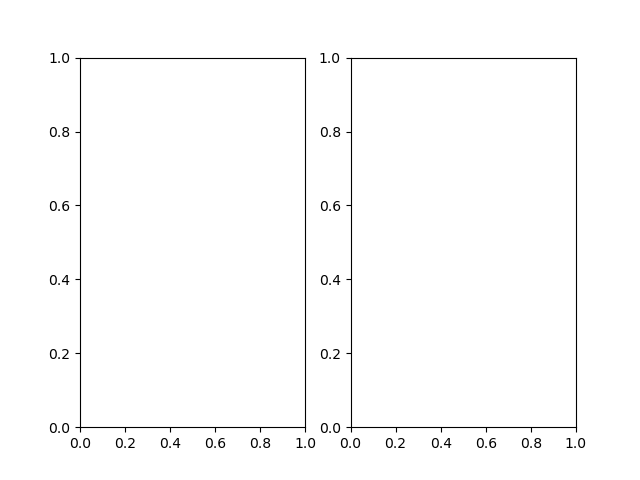

AttributeError: 'Axes' object has no attribute 'polar'

In [20]:
#Initial conditions 1 (Duplicate Berg and Marshall(more or less))
z0 = 0.016              #m
theta0 = 0          #radians  
v0 = 0
rv0 = 0
T = 150        
tfinal = T*2
dt = 0.1
WF1 = Wilberforce(z0,theta0,v0,rv0)
WF1.pendulum(tfinal,dt)
#WF1.plot_motion()
#plt.suptitle("Simulate Berg & Marshall",fontweight='bold')
fig = WF1.animate(5)
# plt.show
#===========================================================================